### Informasi Eksperimen
FLUENT - ICONNIC


DNN (non-cross val; param default) vs RNN (non-cross val; param default) + (2); (3); (4)

(2) evaluasi dengan BLEU (3) analisa dengan 5 prompt pertanyaan yang dispesifikasikan dan 5 prompt bebas dari user (4) menujukkan hasil evaluasi hasil prompt bebas dengan kategori buruk netral baik

Referensi tambahan:
https://www.researchgate.net/publication/336203630_Indonesian_Chatbot_of_University_Admission_Using_a_Question_Answering_System_Based_on_Sequence-to-Sequence_Model

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import preprocessing, utils
import os
import yaml

# Retrieve data train

In [2]:
knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom.xlsx', engine='openpyxl')
knowledgebase.head()

,No,Contributor,Topik/Tag,Pertanyaan,Jenis,Jawaban,Link Jawaban,Keterangan Tambahan
0,0.0,Fitra,Informasi Dosen,email Fitra A. Bachtiar,Statis,fitra.bachtiar[at]ub.ac.id,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
1,NaN,NaN,NaN,NIK/NIP Fitra A. Bachtiar,Statis,198406282019031006,NaN,NaN
2,NaN,NaN,NaN,nama lengkap Fitra A. Bachtiar,Statis,Dr.Eng. Fitra A. Bachtiar,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
3,NaN,NaN,NaN,Departemen Fitra A. Bachtiar,Dinamis,Departemen Teknik Informatika,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
4,NaN,NaN,NaN,Program Studi Fitra A. Bachtiar,Dinamis,S2 Ilmu Komputer,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN


In [3]:
qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


# Implementasi RNN 

## Preprocessing Data

In [4]:
# remove all the punctuation from qa_paired
qa_paired['Pertanyaan'] = qa_paired['Pertanyaan'].str.replace('[^\w\s]',' ').str.lower()
qa_paired['Jawaban'] = qa_paired['Jawaban'].str.replace('[^\w\s]',' ').str.lower()

In [5]:
vocab = sorted(set(" ".join(qa_paired['Pertanyaan'] +" " + qa_paired['Jawaban']).split()))

In [6]:
questions = qa_paired['Pertanyaan']

answers = list()
for i in range( len(qa_paired['Jawaban']) ) :
    answers.append( '<START> ' + " ".join(qa_paired['Jawaban'].iloc[i].split()) + ' <END>' )

tokenizer = preprocessing.text.Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 2601


### Encoder-Decoder

In [7]:
from gensim.models import Word2Vec
import re

In [8]:
vocab = []
for word in tokenizer.word_index:
  vocab.append(word)

def tokenize(sentences):
  tokens_list = []
  vocabulary = []
  for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    tokens = sentence.split()
    vocabulary += tokens
    tokens_list.append(tokens)
  return tokens_list, vocabulary

In [9]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

(1198, 13) 13


In [10]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(1198, 294) 294


In [11]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )

(1198, 294, 2601)


## Modelling

In [12]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# define the checkpoint
checkpoint = ModelCheckpoint('riset/fluent/2023/model_alif/rnn_model_weights_v1.3.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')

In [13]:
# reset model
tf.keras.backend.clear_session()

In [14]:
encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE+1, 500 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 500 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 500 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 500 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 294)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 500)      1301000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 294, 500)     1300500     input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
history = model.fit([encoder_input_data , decoder_input_data], 
                    decoder_output_data, 
                    batch_size=50, 
                    epochs=10,
                    callbacks=[checkpoint, 
                               earlystopping]) 

Epoch 1/10
24/24 [==============================] - 38s 2s/step - loss: 0.3850

Epoch 00001: loss improved from 0.44430 to 0.38497, saving model to riset/fluent/2023/model_alif/rnn_model_weights_v1.3.h5
Epoch 2/10
24/24 [==============================] - 37s 2s/step - loss: 0.3563

Epoch 00002: loss improved from 0.38497 to 0.35626, saving model to riset/fluent/2023/model_alif/rnn_model_weights_v1.3.h5
Epoch 3/10
24/24 [==============================] - 37s 2s/step - loss: 0.3307

Epoch 00003: loss improved from 0.35626 to 0.33067, saving model to riset/fluent/2023/model_alif/rnn_model_weights_v1.3.h5
Epoch 4/10
24/24 [==============================] - 37s 2s/step - loss: 0.3081

Epoch 00004: loss improved from 0.33067 to 0.30813, saving model to riset/fluent/2023/model_alif/rnn_model_weights_v1.3.h5
Epoch 5/10
24/24 [==============================] - 37s 2s/step - loss: 0.2889

Epoch 00005: loss improved from 0.30813 to 0.28892, saving model to riset/fluent/2023/model_alif/rnn_model_w

In [364]:
with open('riset/fluent/2023/model_alif/history_rnn_v1.1_14923.yaml', 'w') as f:
    yaml.dump(history.history, f)

In [206]:
# load model best weights
# model.load_weights('riset/fluent/2023/model_alif/model/rnn_model_weights.h5')
model.load_weights('riset/fluent/2023/model_alif/rnn_model_weights_v1.1.h5')

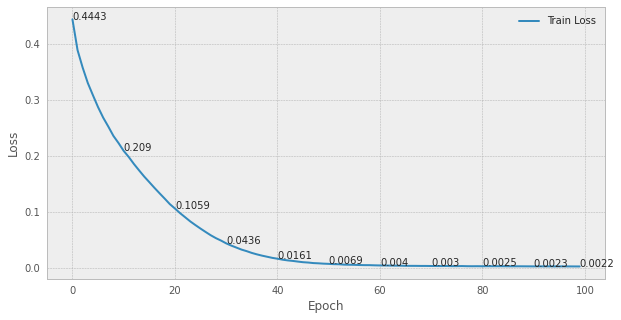

In [354]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
# plt.title('Model CatCross Entropy Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')

for i, loss in enumerate(history.history['loss']):
    # print("Epoch", i, ":", loss)
    if i % 10 == 0 or i == len(history.history['loss']) - 1:
        plt.annotate(str(round(loss, 4)), xy=(i,loss), xytext=(i,loss))
plt.show()

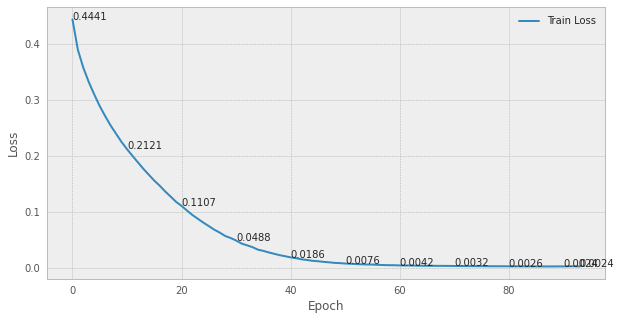

In [112]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
# plt.title('Model CatCross Entropy Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')

for i, loss in enumerate(history.history['loss']):
    # print("Epoch", i, ":", loss)
    if i % 10 == 0 or i == len(history.history['loss']) - 1:
        plt.annotate(str(round(loss, 4)), xy=(i,loss), xytext=(i,loss))
plt.show()


## Test the chatbot

In [17]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 500 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 500 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]

    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [18]:
def str_to_tokens( sentence : str ):

    words = sentence.lower().split()
    tokens_list = list()

    for word in words:
        try:
            tokens_list.append( tokenizer.word_index[ word ] )
        except KeyError:
            tokens_list.append(1)
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [19]:
def get_response_rnn(question):
    enc_model , dec_model = make_inference_models()

    quest = question

    states_values = enc_model.predict( str_to_tokens(quest) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    return decoded_translation.strip()

# quest = input("Masukkan pertanyaan : ")
# print("Pertanyaan : ", quest.strip())
# print("Jawaban : ", get_response_rnn(quest))

# Implementasi DNN 

## Prepocessing Data

In [20]:
qa_paired_dnn = qa_paired
qa_paired_dnn['tag'] = qa_paired_dnn.index
qa_paired

,Pertanyaan,Jawaban,tag
0,email fitra a bachtiar,fitra bachtiar at ub ac id,0
1,nik nip fitra a bachtiar,198406282019031006,1
2,nama lengkap fitra a bachtiar,dr eng fitra a bachtiar,2
3,departemen fitra a bachtiar,departemen teknik informatika,3
4,program studi fitra a bachtiar,s2 ilmu komputer,4
...,...,...,...
1229,apa manfaat konseling filkom,1 masalah ditangani oleh ahli yang kompeten d...,1229
1230,berikan informasi mengenai layanan konseling,informasi mengenai layanan konseling dapat dia...,1230
1231,siapa konselor bimbingan dan konseling di filk...,ada 2 konselor bimbingan dan konseling di filk...,1231
1232,siapa koordinator konselor sebaya,koordinator konselor sebaya adalah muhammad da...,1232


In [21]:
X_train = qa_paired_dnn['Pertanyaan'].astype(str)

In [22]:
# tokenize Pertanyaan using tf 

tokenizer = Tokenizer(oov_token='x')
tokenizer.fit_on_texts(X_train)

doc_X = tokenizer.texts_to_sequences(X_train)
doc_X = pad_sequences(doc_X, maxlen=20, padding='post')

docs_Y = qa_paired_dnn['tag']
docs_Y = np.array(docs_Y).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
doc_Y = encoder.fit_transform(docs_Y)

output_shape = len(doc_Y[0])

## Modelling

In [23]:
#deep learning model
model_dnn = Sequential()
model_dnn.add(Dense(4096, input_shape=(20,), activation="relu"))
model_dnn.add(Dense(4096, activation="relu"))
model_dnn.add(Dense(2048, activation="relu"))
model_dnn.add(Dense(output_shape, activation="sigmoid"))
model_dnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])
print(model_dnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              86016     
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_4 (Dense)              (None, 1198)              2454702   
Total params: 27,712,686
Trainable params: 27,712,686
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
# reset model
tf.keras.backend.clear_session()

In [25]:
checkpoint = ModelCheckpoint('riset/fluent/2023/model_alif/dnn_model_weights_v1.3.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='max')

In [26]:
history_model_dnn = model_dnn.fit(x=doc_X, 
                       y=doc_Y,
                       epochs=10,
                       verbose=1,
                       callbacks=[checkpoint, 
                               earlystopping])

Epoch 1/10
38/38 [==============================] - 4s 83ms/step - loss: 19.8169 - accuracy: 0.0000e+00

Epoch 00001: accuracy improved from -inf to 0.00000, saving model to riset/fluent/2023/model_alif/dnn_model_weights_v1.3.h5
Epoch 2/10
38/38 [==============================] - 3s 83ms/step - loss: 7.0061 - accuracy: 0.0017

Epoch 00002: accuracy improved from 0.00000 to 0.00167, saving model to riset/fluent/2023/model_alif/dnn_model_weights_v1.3.h5
Epoch 3/10
38/38 [==============================] - 3s 82ms/step - loss: 6.1805 - accuracy: 0.0117

Epoch 00003: accuracy improved from 0.00167 to 0.01169, saving model to riset/fluent/2023/model_alif/dnn_model_weights_v1.3.h5
Epoch 4/10
38/38 [==============================] - 3s 83ms/step - loss: 5.4446 - accuracy: 0.0284

Epoch 00004: accuracy improved from 0.01169 to 0.02838, saving model to riset/fluent/2023/model_alif/dnn_model_weights_v1.3.h5
Epoch 5/10
38/38 [==============================] - 3s 83ms/step - loss: 5.0810 - accuracy

In [194]:
model_dnn.load_weights('riset/fluent/2023/model_alif/model/dnn_model_weights.h5')

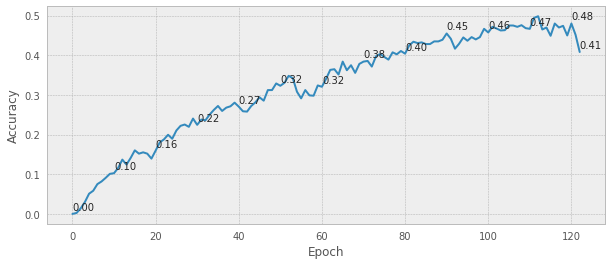

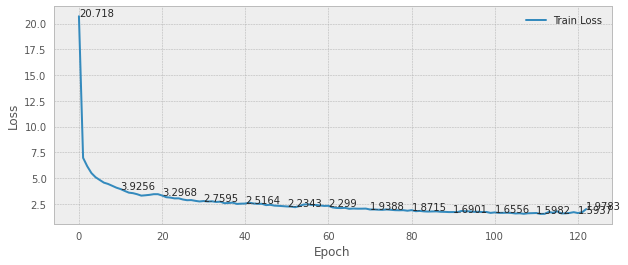

In [114]:
plt.plot(history_model_dnn.history['accuracy'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
# plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

for i, acc in enumerate(history_model_dnn.history['accuracy']):
    if i % 10 == 0 or i == len(history_model_dnn.history['accuracy']) - 1:
        plt.annotate('{:.2f}'.format(acc), xy=(i, acc), xytext=(i, acc + 0.01))

plt.show()

plt.plot(history_model_dnn.history['loss'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
# plt.title('Model CatCross Entropy Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')

for i, loss in enumerate(history_model_dnn.history['loss']):
    # print("Epoch", i, ":", loss)
    if i % 10 == 0 or i == len(history_model_dnn.history['loss']) - 1:
        plt.annotate(str(round(loss, 4)), xy=(i,loss), xytext=(i,loss))
plt.show()

## Test the chatbot

In [195]:
import numpy as np

def get_response_dnn(input_text):
    class_tag = predict_class(input_text)
    response = qa_paired_dnn[qa_paired_dnn['tag'] == class_tag].iloc[0].Jawaban.strip()
    return response

def predict_class(input_text):
    question = preprocess_input(input_text)
    pred = model_dnn.predict(question.reshape(1,20))
    return encoder.inverse_transform(np.array(pred))[0][0]

def preprocess_input(input_text):
    input_text = input_text.lower()
    input_text = re.sub('[^a-zA-Z]', ' ', input_text)
    tokenized_text = tokenizer.texts_to_sequences([input_text])[0]
    tokenized_text = pad_sequences([tokenized_text], maxlen=20, padding='post')[0]

    return tokenized_text

# Comparison Model

## Learning Curve by Loss

In [103]:
history_dnn = {
    'accuracy': history_model_dnn.history['accuracy'],
    'loss': history_model_dnn.history['loss']
}

history_rnn = {
    'loss': history.history['loss']
}

with open('riset/fluent/2023/model_alif/history_dnn_13923.yaml', 'w') as file:
    documents = yaml.dump(history_dnn, file)

with open('riset/fluent/2023/model_alif/history_rnn_13923.yaml', 'w') as file:
    documents = yaml.dump(history_rnn, file)

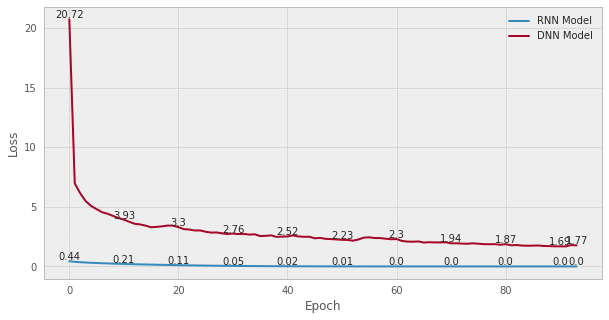

In [124]:
# remove whitegrid
plt.style.use('bmh')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

loss_rnn = history.history['loss'][:94]
loss_dnn = history_model_dnn.history['loss'][:94]

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.plot(loss_rnn, label='RNN Model')
plt.plot(loss_dnn, label='DNN Model')
plt.legend()

# Add value labels for every 20 epochs
for i, loss in enumerate(loss_rnn):
    if i % 10 == 0 or i == 93:
        plt.annotate(str(round(loss, 2)), xy=(i, loss), xytext=(i, loss+0.1), ha='center')

for i, loss in enumerate(loss_dnn):
    if i % 10 == 0 or i == 93:
        plt.annotate(str(round(loss, 2)), xy=(i, loss), xytext=(i, loss+0.1), ha='center')

plt.show()

## Answering Quesitons

In [293]:
tables = pd.read_csv('riset/fluent/2023/model_alif/rnn_preds_answers.csv')
tables.drop(columns=['pred_answers'], inplace=True)

prompts = [
    {
        "question": "email fajar pradana",
        "expected": tables[tables['questions'].str.contains("email fajar pradana").fillna(False)].iloc[0].real_answers.strip()
    },{
        "question": "kalender akademik",
        "expected": tables[tables['questions'].str.contains("kalender akademik").fillna(False)].iloc[0].real_answers.strip()
    },{
        "question": "informasi yudisium",
        "expected": tables[tables['questions'].str.contains("informasi yudisium").fillna(False)].iloc[0].real_answers.strip()
    },{
        "question": "apa itu laboratorium sistem cerdas",
        "expected": tables[tables['questions'].str.contains("laboratorium sistem cerdas").fillna(False)].iloc[2].real_answers.strip()
    },{
        "question": "ketua senat filkom",
        "expected": tables[tables['questions'].str.contains("ketua senat").fillna(False)].iloc[0].real_answers.strip()
    },{
        "question": "apa itu bcc",
        "expected": tables[tables['real_answers'].str.contains("bcc").fillna(False)].iloc[1].real_answers.strip()
    },{
        "question": "apa manfaat konseling di filkom",
        "expected": tables[tables['real_answers'].str.contains("terarah").fillna(False)].iloc[0].real_answers.strip()
    }

]

In [294]:
human_eval = pd.DataFrame(columns=['question', 'real_answers', 'rnn_answers', 'dnn_answers'])

for prompt in prompts:
    question = prompt['question']
    real_answer = prompt['expected']

    rnn_answer = get_response_rnn(question)
    dnn_answer = get_response_dnn(question)

    human_eval = human_eval.append({
        'question': question,
        'real_answers': real_answer,
        'rnn_answers': rnn_answer,
        'dnn_answers': dnn_answer
    }, ignore_index=True)

In [295]:
human_eval.to_csv('riset/fluent/2023/model_alif/human_eval.csv', index=False)
human_eval

,question,real_answers,rnn_answers,dnn_answers
0,email fajar pradana,fajar p at ub ac id,fajar p at ub ac id end,bayu_priyambadha at ub ac id
1,kalender akademik,https filkom ub ac id pendidikan kalender akad...,https filkom ub ac id pendidikan kalender akad...,merdeka filkom merupakan portal merdeka belaja...
2,informasi yudisium,https filkom ub ac id wp content uploads 2021 ...,https filkom ub ac id wp content uploads 2021 ...,halofilkom merupakan platform ticketing yang d...
3,apa itu laboratorium sistem cerdas,laboratorium sistem cerdas merupakan salah sat...,laboratorium sistem cerdas merupakan salah sat...,laboratorium sistem cerdas merupakan salah sat...
4,ketua senat filkom,tri astoto kurniawan s t m t ph d,tri astoto kurniawan s t m t ph d end,https filkom ub ac id wp content uploads 202...
5,apa itu bcc,bcc merupakan komunitas yang berada dibawah na...,bcc merupakan komunitas yang berada dibawah na...,laboratorium sistem cerdas merupakan salah sat...
6,apa manfaat konseling di filkom,1 masalah ditangani oleh ahli yang kompeten di...,1 masalah ditangani oleh ahli yang kompeten di...,nurudin santoso s t m t


In [306]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_strings(str1, str2):
    # create a CountVectorizer object
    vectorizer = CountVectorizer()

    # create a matrix of word counts for each string
    matrix = vectorizer.fit_transform([str1, str2])

    # calculate the cosine similarity between the two strings
    cosine_sim = cosine_similarity(matrix[0], matrix[1])[0][0]

    return cosine_sim


In [304]:
human_eval_results = pd.DataFrame(columns=['prompt', 'rnn_valid', 'dnn_valid'])

for res in human_eval.iterrows():
    prompt = res[1].question
    real_answer = res[1].real_answers
    rnn_words = res[1].rnn_answers.split()
    rnn_count = 0
    dnn_words = res[1].dnn_answers.split()
    dnn_count = 0
    for word in rnn_words:
        if word in real_answer:
            rnn_count += 1
    for word in dnn_words:
        if word in real_answer:
            dnn_count += 1
    threshold = len(real_answer.split()) * 0.7
    rnn_result = rnn_count >= threshold
    dnn_result = dnn_count >= threshold
    human_eval_results = human_eval_results.append({
        'prompt': prompt,
        'rnn_valid': rnn_result,
        'dnn_valid': dnn_result
    }, ignore_index=True)

In [305]:

human_eval_results

,prompt,rnn_valid,dnn_valid
0,email fajar pradana,True,False
1,kalender akademik,True,False
2,informasi yudisium,True,False
3,apa itu laboratorium sistem cerdas,True,True
4,ketua senat filkom,True,False
5,apa itu bcc,True,False
6,apa manfaat konseling di filkom,True,False


In [199]:
intent = [
    "Email fajar pradana",
    "info kalender akademik",
    "informasi yudisium" ,
    "surat edaran skripsi",
    "laboratorium sistem cerdas"
]

In [217]:
rnn_scores_by_user = []
dnn_scores_by_user = []

user_questions = []

for i in intent:
    pertanyaan_user = input("Masukkan pertanyaan anda berdasarkan intent " + i + " : ")
    user_questions.append(pertanyaan_user)
    print("Pertanyaan : ", pertanyaan_user.strip())
    print("Jawaban RNN : ", get_response_rnn(i))
    print("Jawaban DNN : ", get_response_dnn(i))
    print("")
    rnn_score = input("Bagaimana menurut anda jawaban RNN? (p: poor, n: neutral, g: good) : ")
    dnn_score = input("Bagaimana menurut anda jawaban DNN? (p: poor, n: neutral, g: good) : ")
    print("RNNScore : ", rnn_score)
    print("DNNScore : ", dnn_score)
    rnn_scores_by_user.append(rnn_score)
    dnn_scores_by_user.append(dnn_score)
    print("-------next intent--------")


Pertanyaan :  Halo, anda adalah seorang mahasiswa yang juga merupakan pengurus BEM FILKOM UB. Anda betugas sebagai pengurus advokasi yang juga menjadi penghubung atas segala informasi terkait akademik dan kebijakan-kebijakan yang baru saja diupdate dan berlaku. Pada kasus kali ini, anda diminta untuk menjadi penghubung antara mahasiswa semester akhir dan salah satu dosen yang bertugas untuk membimbingnya mengerjakan skripsi, yaitu Pak Fajar Pradana. Tolong carikan seluruh kontak media sosial Pak Fajar Pradana yang dapat dihubungi, setidaknya alamat emailnya.
Jawaban RNN :  fajar p at ub ac id end
Jawaban DNN :  tugas utama gjm adalah melakukan penjaminan mutu akademik internal untuk mencapai beberapa tujuan sebagai berikut  
1  kesesuaian terhadap kebijakan akademik  standar akademik  peraturan akademik dan manual mutu akademik
2  kepastian bahwa setiap siswa memiliki pengalaman belajar sesuai dengan spesifikasi program studi
3  kepastian bahwa lulusan memiliki kompetensi sesuai dengan

In [377]:
# pengujian pertama
user_eval = pd.DataFrame(columns=['intent', 'user_question', 'rnn_score', 'dnn_score'])

def translate_score(score):
    if score == 'p':
        return 'Positive'
    elif score == 'n':
        return 'Negative'
    else:
        return 'Neutral'

for i in range(len(intent)):
    user_eval = user_eval.append({
        'intent': intent[i],
        'user_question': user_questions[i],
        'rnn_score': translate_score(rnn_scores_by_user[i]),
        'dnn_score': translate_score(dnn_scores_by_user[i])
    }, ignore_index=True)  

user_eval 

,intent,user_question,rnn_score,dnn_score
0,Email fajar pradana,berikan saya email bapak fajar pradana,Positive,Negative
1,info kalender akademik,dimana saya dapat mengakses informasi kalender...,Positive,Negative
2,informasi yudisium,kapan jadwal pelaksanaan yudisium FILKOM UB,Negative,Negative
3,surat edaran skripsi,berikan saya informasi mengenai surat edaran s...,Negative,Negative
4,laboratorium sistem cerdas,apa itu laboratorium sistem cerdas,Positive,Positive


In [215]:
# pengujian kedua
user_eval = pd.DataFrame(columns=['intent', 'user_question', 'rnn_score', 'dnn_score'])

def translate_score(score):
    if score == 'p':
        return 'poor'
    elif score == 'n':
        return 'neutral'
    else:
        return 'good'

for i in range(len(intent)):
    user_eval = user_eval.append({
        'intent': intent[i],
        'user_question': user_questions[i],
        'rnn_score': translate_score(rnn_scores_by_user[i]),
        'dnn_score': translate_score(dnn_scores_by_user[i])
    }, ignore_index=True)  

user_eval 

,intent,user_question,rnn_score,dnn_score
0,Email fajar pradana,apa email fajar pradana ?,good,poor
1,info kalender akademik,kapan waktu pelaksanaan UTS dan UAS ?,good,poor
2,informasi yudisium,kapan pelaksanaan yudisium ?,neutral,poor
3,surat edaran skripsi,kapan pelaksanaan skripsi ?,good,poor
4,laboratorium sistem cerdas,kapan pelaksanaan praktikum di laboratorium si...,neutral,neutral


In [218]:
# pengujian ketiga
user_eval = pd.DataFrame(columns=['intent', 'user_question', 'rnn_score', 'dnn_score'])

def translate_score(score):
    if score == 'p':
        return 'poor'
    elif score == 'n':
        return 'neutral'
    else:
        return 'good'

for i in range(len(intent)):
    user_eval = user_eval.append({
        'intent': intent[i],
        'user_question': user_questions[i],
        'rnn_score': translate_score(rnn_scores_by_user[i]),
        'dnn_score': translate_score(dnn_scores_by_user[i])
    }, ignore_index=True)  

user_eval 

,intent,user_question,rnn_score,dnn_score
0,Email fajar pradana,"Halo, anda adalah seorang mahasiswa yang juga ...",good,poor
1,info kalender akademik,Sekarang tanggal 14 september 2023. Apa agenda...,poor,poor
2,informasi yudisium,Saya ingin mengambil melaksanakan ujian akhir ...,neutral,poor
3,surat edaran skripsi,"Untuk semester ini, apakah terdapat perubahan ...",neutral,poor
4,laboratorium sistem cerdas,Saya dengar terdapat fasilitas laboratorium-la...,good,good


## BLEU Score

In [27]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    bleu_score_all = 0

    num_of_rows_calculated = 0

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        try:
            refs = [real_answer.split(' ')]
            hyp = preds[i].split(' ')

            bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0))
            bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0))
            bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0))
            bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1))
            bleu_score_all += sentence_bleu(refs, hyp, weights=(.25,.25,.25,.25))

            num_of_rows_calculated+=1
        except:
            continue

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_all/num_of_rows_calculated)}
    
    return results

### RNN Scoring

In [228]:
tables = pd.read_csv('riset/fluent/2023/model_alif/rnn_preds_answers.csv')

rnn_bleu = calculate_bleu(tables['pred_answers'], tables['questions'], tables['real_answers'])
rnn_bleu['mean'] = np.mean(list(rnn_bleu.values()))

/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunctio

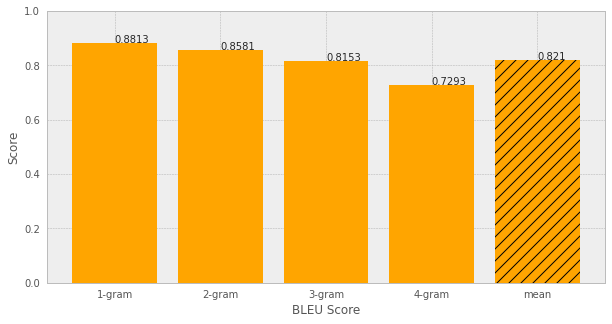

<Figure size 1440x720 with 0 Axes>

In [231]:
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(rnn_bleu.items()):
    if index == len(rnn_bleu.values()) - 1:
        plt.bar(index, value, color='orange', hatch='//')
    else:
        plt.bar(index, value, color='orange')
    plt.text(index, value, str(round(value, 4)))
plt.xticks(range(len(rnn_bleu)), rnn_bleu.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.figure(figsize=(20, 10))
plt.show()

### DNN Scoring

In [ ]:
dnn_preds_answers = []
for question in tables['questions']:
    try:
        dnn_preds_answers.append(get_response_dnn(question))
    except:
        dnn_preds_answers.append('tidak mengerti input')
        print(question)

In [ ]:
dnn_bleu = calculate_bleu(dnn_preds_answers, tables['questions'], tables['real_answers'])
dnn_bleu['mean'] = np.mean(list(dnn_bleu.values()))

NameError: name 'dnn_bleu' is not defined

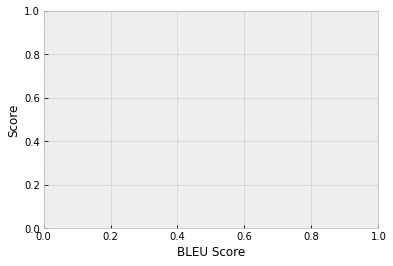

In [30]:
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(dnn_bleu.items()):
    if index == len(dnn_bleu.values()) - 1:
        plt.bar(index, value, color='orange', hatch='//')
    else:
        plt.bar(index, value, color='orange')
    plt.text(index, value, str(round(value, 4)))
plt.xticks(range(len(dnn_bleu)), dnn_bleu.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.figure(figsize=(20, 10))
plt.show()

### Comparison BLEU Score

NameError: name 'rnn_bleu' is not defined

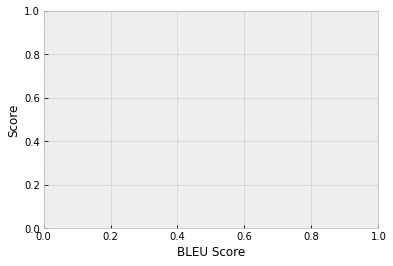

In [29]:
# combine and compare two bleu score in grouped bar chart
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(rnn_bleu.items()):
    if index == len(rnn_bleu.values()) - 1:
        plt.bar(index, value, color='orange', hatch='//', label='RNN Model')
    else:
        plt.bar(index, value, color='orange', label='_nolegend_')
    plt.text(index, value, str(round(value, 4)))
for index, (key, value) in enumerate(dnn_bleu.items()):
    if index == len(dnn_bleu.values()) - 1:
        plt.bar(index+0.2, value, color='blue', hatch='//', label='DNN Model')
    else:
        plt.bar(index+0.2, value, color='blue', label='_nolegend_')
    plt.text(index+0.2, value, str(round(value, 4)))
plt.xticks(range(len(rnn_bleu)), rnn_bleu.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.legend()
plt.figure(figsize=(20, 10))
plt.show()

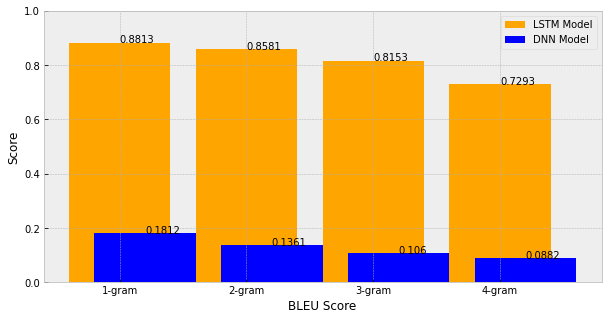

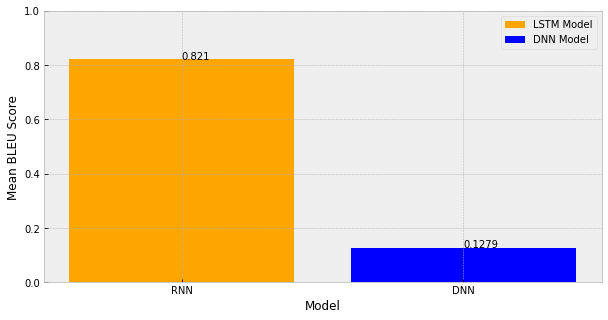

<Figure size 720x360 with 0 Axes>

In [34]:
import numpy as np
import matplotlib.pyplot as plt

bleuRNN = {'1-gram': 0.8813, '2-gram': 0.8581, '3-gram': 0.8153, '4-gram': 0.7293}
bleuDNN = {'1-gram': 0.1812, '2-gram': 0.1361, '3-gram': 0.106, '4-gram': 0.0882}

rnn_mean_bleu = np.mean(list(bleuRNN.values()))
dnn_mean_bleu = np.mean(list(bleuDNN.values()))

plt.figure(figsize=(10, 5))
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(bleuRNN.items()):
    if index == len(bleuRNN.values()) - 1:
        plt.bar(index, value, color='orange', label='LSTM Model')
    else:
        plt.bar(index, value, color='orange', label='_nolegend_')
    plt.text(index, value, str(round(value, 4)))
for index, (key, value) in enumerate(bleuDNN.items()):
    if index == len(bleuDNN.values()) - 1:
        plt.bar(index+0.2, value, color='blue', label='DNN Model')
    else:
        plt.bar(index+0.2, value, color='blue', label='_nolegend_')
    plt.text(index+0.2, value, str(round(value, 4)))
plt.xticks(range(len(bleuRNN)), bleuRNN.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.legend()
plt.show()

plt.style.use('bmh')
plt.figure(figsize=(10, 5))
plt.xlabel('Model')
plt.ylabel('Mean BLEU Score')
plt.bar('RNN', rnn_mean_bleu, color='orange', label='LSTM Model')
plt.bar('DNN', dnn_mean_bleu, color='blue', label='DNN Model')
plt.text(0, rnn_mean_bleu, str(round(rnn_mean_bleu, 4)))
plt.text(1, dnn_mean_bleu, str(round(dnn_mean_bleu, 4)))
plt.yticks(np.arange(0, 1.03, 0.2))
plt.legend()
plt.figure(figsize=(10, 5))
plt.show()
